In [1]:
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image


In [2]:
img=Image.open('/kaggle/input/cat-dataset/cat.jpg').convert('RGB')

img=img.resize((64,64))


transform=transforms.ToTensor()

img_tensor=transform(img).unsqueeze(0)


In [3]:

img_np=np.array(img)

#apply gaussian blur

blurred_np=cv2.GaussianBlur(img_np,(5,5),0)
#convert to tensor
blurred_tensor = torch.tensor(blurred_np / 255.0).permute(2,0,1).unsqueeze(0).float()

In [4]:
#create Neural net 
from torchinfo import summary


class BlurNet(nn.Module):  # Class name can be BlurNet (PEP8 style)
    def __init__(self):
        super().__init__()  # remove the extra colon
        self.conv = nn.Conv2d(3, 3, kernel_size=5, padding=2)
 
    def forward(self, x):
        return self.conv(x)

# Instantiate the model
model = BlurNet()



input_size = (1, 3, 32, 32)
print(summary(model,input_size))

Layer (type:depth-idx)                   Output Shape              Param #
BlurNet                                  [1, 3, 32, 32]            --
├─Conv2d: 1-1                            [1, 3, 32, 32]            228
Total params: 228
Trainable params: 228
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.23
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.04


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BlurNet().to(device)
img_tensor = img_tensor.to(device)
blurred_tensor = blurred_tensor.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train for 500 iterations
for i in range(1000):
    optimizer.zero_grad()
    output = model(img_tensor)
    loss = criterion(output, blurred_tensor)
    loss.backward()
    optimizer.step()
    
    if i % 50 == 0:
        print(f"Step {i}, Loss: {loss.item():.6f}")


Step 0, Loss: 0.500685
Step 50, Loss: 0.004429
Step 100, Loss: 0.001965
Step 150, Loss: 0.001260
Step 200, Loss: 0.000904
Step 250, Loss: 0.000712
Step 300, Loss: 0.000599
Step 350, Loss: 0.000524
Step 400, Loss: 0.000471
Step 450, Loss: 0.000431
Step 500, Loss: 0.000399
Step 550, Loss: 0.000374
Step 600, Loss: 0.000353
Step 650, Loss: 0.000335
Step 700, Loss: 0.000320
Step 750, Loss: 0.000307
Step 800, Loss: 0.000295
Step 850, Loss: 0.000284
Step 900, Loss: 0.000275
Step 950, Loss: 0.000266


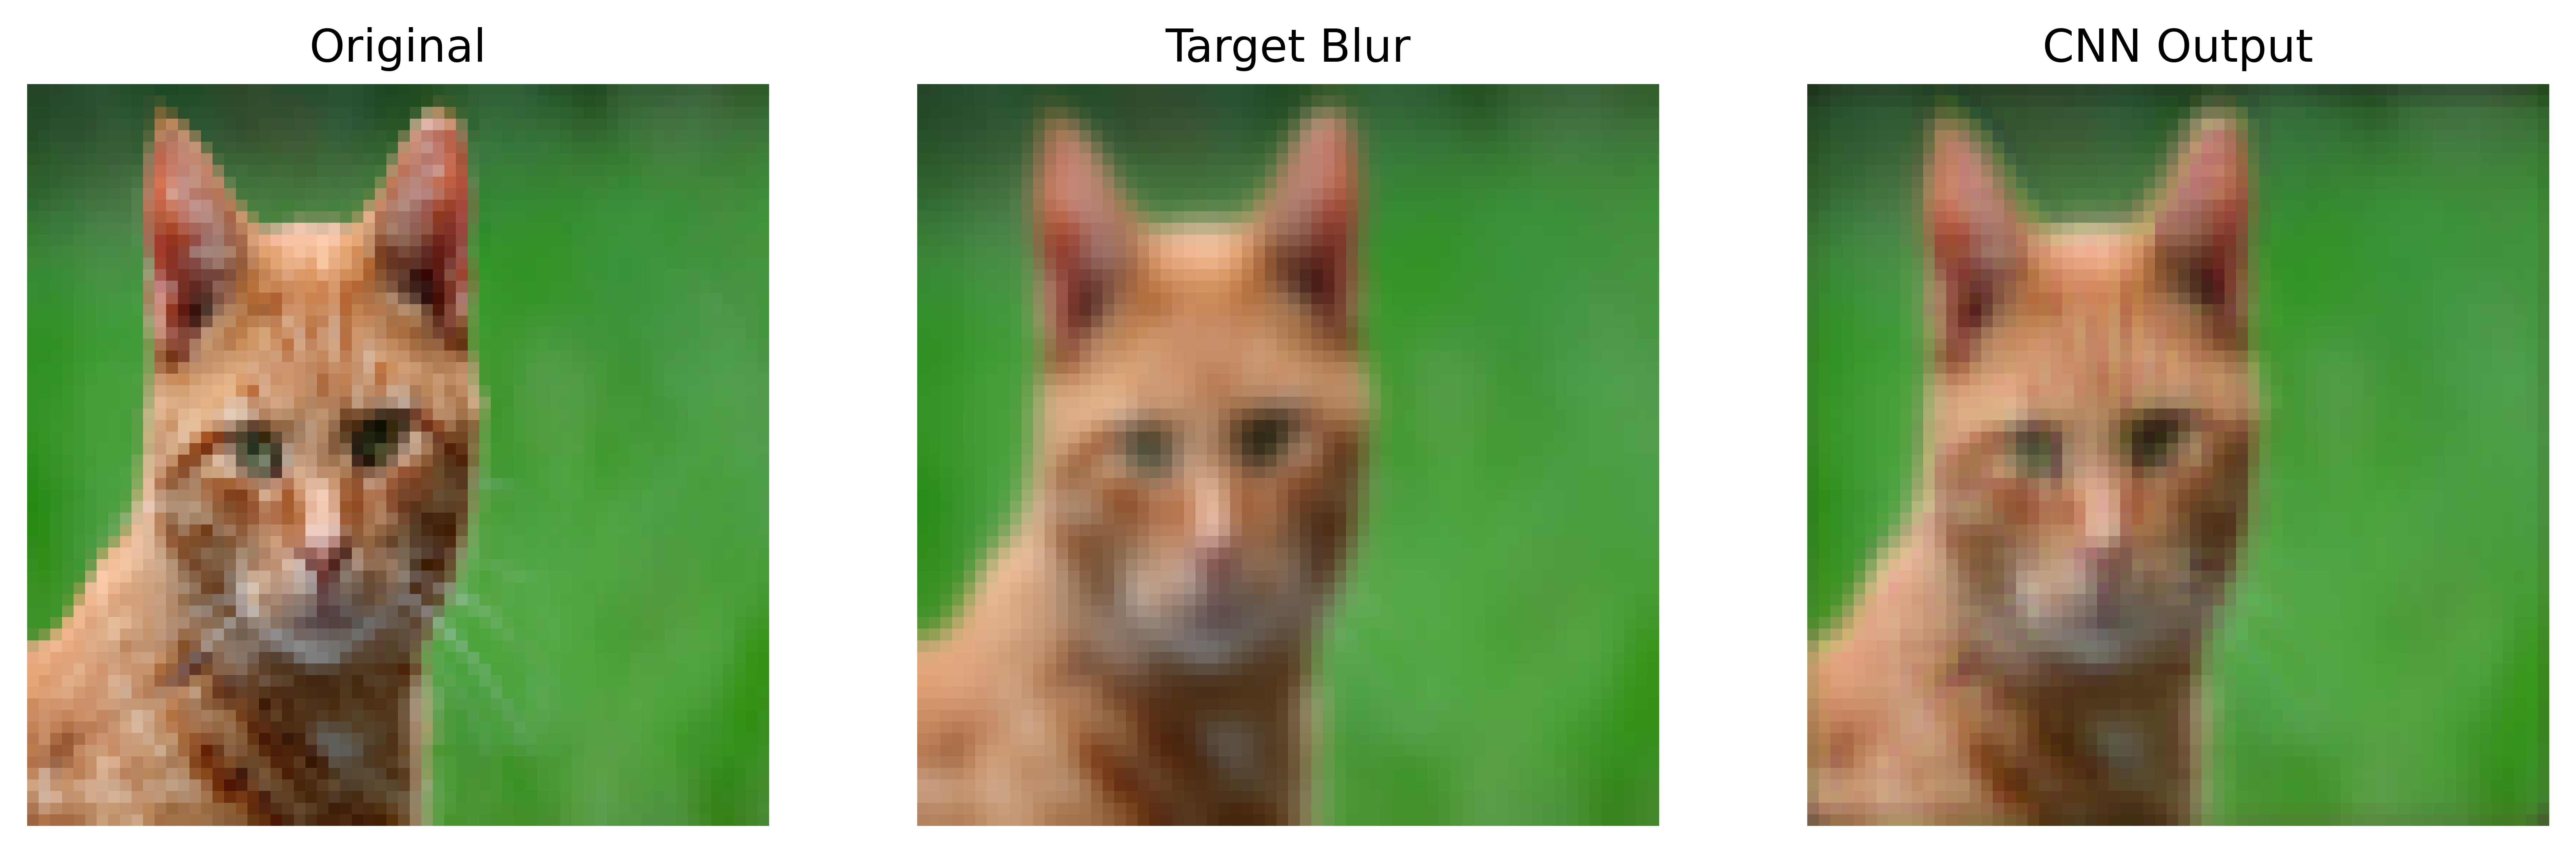

In [6]:
with torch.no_grad():
    output_img = model(img_tensor).cpu().squeeze().permute(1,2,0).numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4),dpi=800)
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_tensor.cpu().squeeze().permute(1,2,0).numpy())
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Target Blur")
plt.imshow(blurred_tensor.cpu().squeeze().permute(1,2,0).numpy())
plt.axis('off')

plt.subplot(1,3,3)
plt.title("CNN Output")
plt.imshow(np.clip(output_img,0,1))
plt.axis('off')
plt.show()
